In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm, mannwhitneyu, ttest_ind, shapiro
from tqdm.auto import tqdm

In [42]:
# загрузим данные
df = pd.read_csv('/home/jupyter-m.gikalo-16/hw_bootstrap.csv', sep = ';')
df

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control
...,...,...,...
995,996,1000,Treatment
996,997,1200,Treatment
997,998,1500,Treatment
998,999,2000,Treatment


In [43]:
# посмотрим на типы данных
df.dtypes

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

In [44]:
# поищем пропуски в данных
df.isna().sum()

Unnamed: 0           0
value                0
experimentVariant    0
dtype: int64

In [45]:
# преобразуем переменную value в числовой тип
df['value'] = df.value.str.replace(',', '.')
df['value'] = pd.to_numeric(df.value)

In [46]:
# зададим тестовые группы
control = df.query('experimentVariant == "Control"').value
treatment = df.query('experimentVariant == "Treatment"').value

In [47]:
# посмотрим на среднее и медиану в контроле
control.describe()[['mean', '50%']]

mean    10.026867
50%     10.018465
Name: value, dtype: float64

In [48]:
# и в тесте
treatment.describe()[['mean', '50%']]

mean    27.321499
50%     10.025847
Name: value, dtype: float64

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


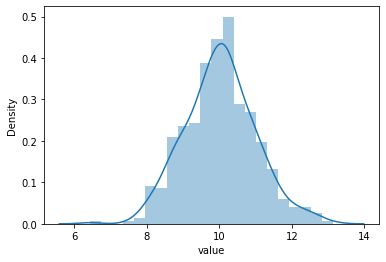

In [49]:
# построим распределение признака для контрольной и тестовой групп
sns.distplot(control)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


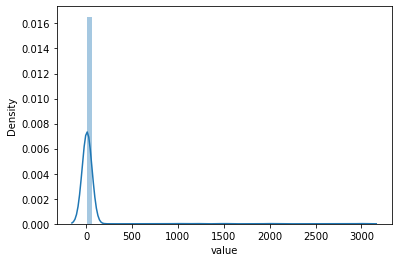

In [50]:
sns.distplot(treatment)

In [51]:
# оценим выбросы

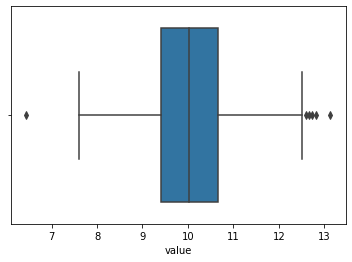

In [52]:
sns.boxplot(x= control)

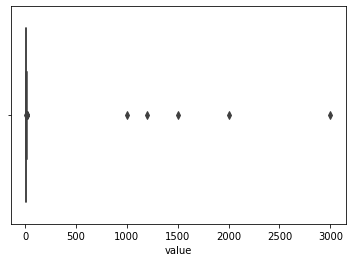

In [53]:
sns.boxplot(x = treatment)

В контрольной группе распределение близко к нормальному. В тестовой группе распределение сильно отличается от нормального за счёт очень ярко выраженных выбросов в правой части графика.
Оценим разницу между контрольной и тестовой группами с помощью непараметрического критерия Манна-Уитни.

In [54]:
mannwhitneyu(treatment, control).pvalue

0.8592148582485579

In [55]:
# Воспользуемся функцией для бутстрапа из лекции
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    statistic, # интересующая нас статистика
    bootstrap_conf_level = 0.95, # уровень значимости
    boot_it = 1000 # количество бутстрэп-подвыборок
    ):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    sns.distplot(pd_boot_data[0])
       
    return {"ci": ci, 
            "p_value": p_value}

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


{'ci':                0
 0.025 -35.542223
 0.975  -4.092483,
 'p_value': 0.03528288874951824}

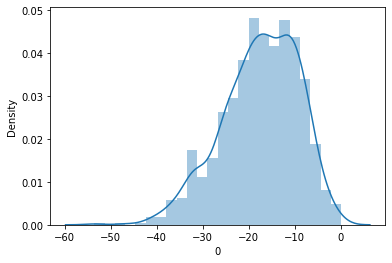

In [56]:
# запустим бутстрап для средних
get_bootstrap(control, treatment, statistic = np.mean)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


{'ci':               0
 0.025 -0.155749
 0.975  0.145952,
 'p_value': 0.9223038894460484}

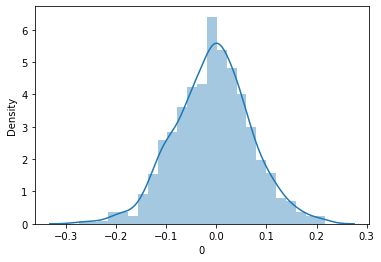

In [57]:
# теперь запустим бутстрап для медиан
get_bootstrap(control, treatment, statistic = np.median)

In [58]:
# Уберём 5 экстремально больших выбросов из тестовой выборки и построим распределение
treat = df.query('experimentVariant == "Treatment"').sort_values('value').reset_index()[0:494].value

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


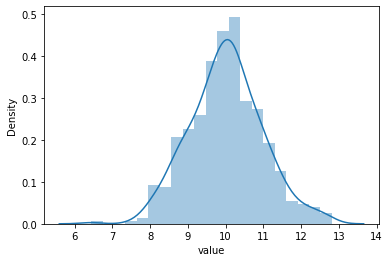

In [59]:
sns.distplot(treat)

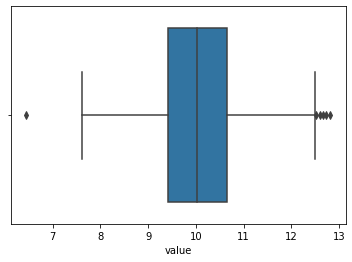

In [60]:
sns.boxplot(x = treat)

In [27]:
shapiro(control).pvalue

0.22416365146636963

In [28]:
shapiro (treat).pvalue

0.24110229313373566

In [25]:
from scipy.stats import levene

In [29]:
levene(control, treat).pvalue

0.8500437925698866

In [32]:
ttest_ind(control, treat).pvalue

0.853149003855713

In [33]:
mannwhitneyu(control, treat).pvalue

0.8790787832087351